In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

import seaborn as sns


from seism_func import get_seism_cube, seism_vectors, get_seism_index

### Формирование и сохранение в файл данных скважин: 

* Kоординаты скважины, 
* Отсечки пласта по метрам и секундам

In [2]:
df_well_coord = pd.read_csv("../Gis_analise/Proc_well_coord.csv", delimiter=";").drop_duplicates()
df_top_ms = pd.read_csv("../Gis_analise/omsk/Well_TOP.csv", delimiter=";", usecols=["Well", "TWT"]).dropna().drop_duplicates(subset=["Well"])
df_bottom_ms = pd.read_csv("seism_data/Well_bottom_time.txt", delimiter="\t", usecols=["Well identifier", "Bot, ms"]).dropna().drop_duplicates(subset=["Well identifier"])

df_well_coord.set_index("Unnamed: 0", inplace=True)
df_top_ms.set_index("Well", inplace=True)
df_bottom_ms.set_index("Well identifier", inplace=True)
df_well_coord.index.name, df_bottom_ms.index.name, df_top_ms.index.name = ["Well"]*3

df_well_coord.columns = ["x", "y", "top_z", "bottom_z"]
df_top_ms.columns = ["top_t"]
df_bottom_ms.columns = ["bottom_t"]

df_info = pd.concat([df_well_coord, df_top_ms, df_bottom_ms], axis=1, join="inner")

In [3]:
print(list(df_info.index))
df_info

['g274', 'g276', 'g277', 'g278', 'g279', 'g280', 'g281', 'g282', 'g288', 'g291', 'g292', 'g293', 'g294', 'g295', 'g297', 'g299', 'g300', 'g301', 'g309', 'g310', 'g311', 'g314', 'g315', 'g319', 'g320', 'g321', 'g325', 'g326', 'g327', 'g328', 'g329', 'g330', 'g332', 'g334', 'g336', 'g337', 'g338', 'g339', 'g340', 'g341', 'g342', 'g343', 'g345', 'g346', 'g347', 'g348', 'g351', 'g352', 'g353', 'g354', 'g356', 'g358', 'g360', 'g361', 'g362', 'g372', 'g373', 'g375', 'g377', 'g382', 'g384', 'g385', 'g386', 'g387', 'g388', 'g389', 'g397', 'g398', 'g400', 'g401', 'g402', 'g403', 'g407', 'g408', 'g409', 'g410', 'g412', 'g414', 'g422', 'g423', 'g425', 'g432', 'g433', 'g434', 'g435', 'g436', 'g442', 'g443', 'g452', 'g453', 'g455', 'g461', 'g463', 'g464', 'g470', 'g471', 'g472', 'g476', 'g483', 'g489', 'g490', 'g496', 'g498', 'g501', 'g506', 'g507', 'g508', 'g513', 'g514', 'g515', 'g517', 'g518', 'g520', 'g531', 'g532', 'g534', 'g540', 'g541', 'g542', 'g543', 'g544', 'g545', 'g547', 'g549', 'g550',

,x,y,top_z,bottom_z,top_t,bottom_t
Well,,,,,,
g274,531608.23,6421427.75,2952.5,2992.9,-2112.48,-2151
g276,530155.25,6413678.34,2886.7,2924.5,-2149.20,-2192
g277,530745.09,6413681.03,2844.5,2881.8,-2140.57,-2194
g278,530083.39,6413163.24,2818.7,2854.7,-2142.02,-2202
g279,530429.23,6413182.18,2780.1,2815.3,-2137.48,-2201
...,...,...,...,...,...,...
g556,531097.45,6414599.81,3324.3,3363.0,-2142.59,-2182
g557,531556.80,6414379.37,3321.7,3360.5,-2140.13,-2187
g558,530704.10,6414130.92,3027.6,3066.0,-2144.22,-2192


In [4]:
df_info_filt = df_info.copy()
df_info_filt["delta_z"] = df_info_filt["bottom_z"] - df_info_filt["top_z"]
df_info_filt["delta_t"] = df_info_filt["top_t"] - df_info_filt["bottom_t"]

trash_delta_z = 47.5
trash_delta_t = 20
df_info_filt = df_info_filt[df_info_filt["delta_z"]<trash_delta_z]
df_info_filt = df_info_filt[df_info_filt["delta_t"]>trash_delta_t]

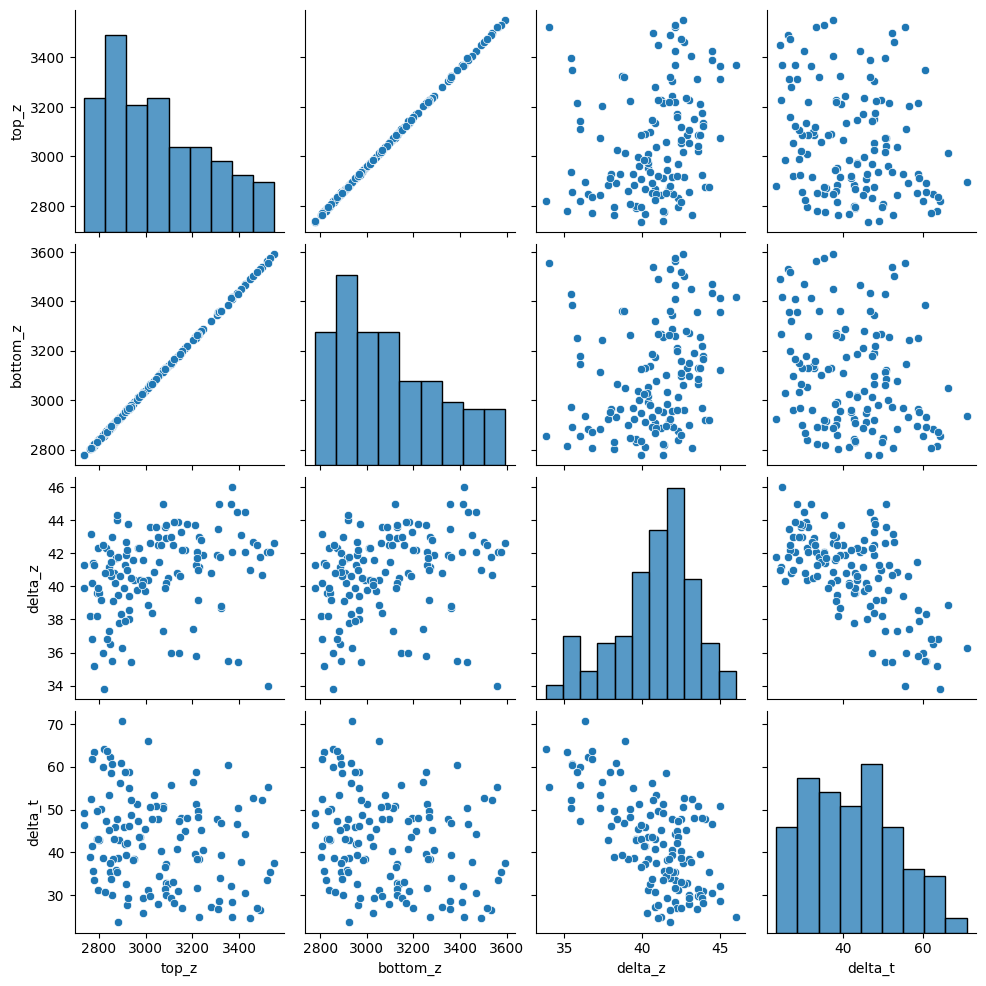

In [9]:
sns.pairplot(df_info_filt[["top_z","bottom_z","delta_z", "delta_t"]])

In [5]:
df_info_filt.to_excel("Wells_info.xlsx")
df_info_filt.to_csv("Wells_info.csv")

PermissionError: [Errno 13] Permission denied: 'Wells_info.xlsx'

### Получение данных от сейсмокуба по координатам скважины 

In [5]:
#l_wells = ['g274', 'g276', 'g277', 'g278', 'g279', 'g280', 'g281']
l_wells = list(df_info_filt.index)

ar_x = df_info_filt.loc[l_wells, "x"].to_list()
ar_y = df_info_filt.loc[l_wells, "y"].to_list()
ar_top_z = df_info_filt.loc[l_wells, "top_z"].to_list()
ar_bottom_z = df_info_filt.loc[l_wells, "bottom_z"].to_list()
ar_top_t = df_info_filt.loc[l_wells, "top_t"].to_list()
ar_bottom_t = df_info_filt.loc[l_wells, "bottom_t"].to_list()

In [6]:
ar_seism = get_seism_cube(file_dir="seism_data")

In [7]:
z_index = get_seism_index(ar_seism.shape[2],ar_top_z, ar_bottom_z, ar_top_t, ar_bottom_t)
Wells_index_seism = pd.DataFrame(z_index.T)
Wells_index_seism.columns = df_info_filt.index
Wells_index_seism

Well,g274,g276,g277,g278,g279,g280,g281,g282,g288,g291,...,g551,g552,g553,g554,g555,g556,g557,g558,g559,g581
0,7055.931776,6374.544860,5595.450047,5184.700667,4962.078841,5155.574735,5167.648591,4902.412660,9134.109365,6319.387786,...,7493.316940,7786.838214,6785.453468,6816.508523,5630.235837,7195.861355,6583.424856,6197.504730,5759.369091,5941.561527
1,7056.372274,6374.915794,5595.743253,5184.952751,4962.311587,5155.820487,5167.894266,4902.633988,9134.721349,6319.753282,...,7493.772678,7787.364104,6785.859104,6816.900253,5630.533430,7196.273788,6583.772541,6197.842277,5759.669964,5941.819336
2,7056.812773,6375.286729,5596.036459,5185.204835,4962.544332,5156.066239,5168.139941,4902.855316,9135.333333,6320.118779,...,7494.228415,7787.889994,6786.264740,6817.291983,5630.831023,7196.686222,6584.120226,6198.179824,5759.970836,5942.077144
3,7057.253271,6375.657664,5596.329665,5185.456919,4962.777078,5156.311991,5168.385615,4903.076645,9135.945318,6320.484275,...,7494.684153,7788.415885,6786.670376,6817.683712,5631.128615,7197.098655,6584.467911,6198.517371,5760.271709,5942.334952
4,7057.693769,6376.028598,5596.622871,5185.709003,4963.009824,5156.557743,5168.631290,4903.297973,9136.557302,6320.849771,...,7495.139891,7788.941775,6787.076012,6818.075442,5631.426208,7197.511089,6584.815596,6198.854918,5760.572582,5942.592760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1896,7891.116822,7077.836822,6151.368744,5662.651984,5403.364484,5621.520231,5633.447899,5322.051200,10294.431565,7012.368550,...,8357.395628,8783.926286,7554.539017,7559.228302,6194.471453,7977.835067,7242.635780,6837.494014,6329.823782,6430.366005
1897,7891.557321,7078.207757,6151.661950,5662.904068,5403.597229,5621.765983,5633.693574,5322.272529,10295.043549,7012.734046,...,8357.851366,8784.452176,7554.944653,7559.620032,6194.769046,7978.247501,7242.983465,6837.831561,6330.124655,6430.623813
1898,7891.997819,7078.578692,6151.955156,5663.156152,5403.829975,5622.011735,5633.939249,5322.493857,10295.655534,7013.099542,...,8358.307104,8784.978067,7555.350289,7560.011762,6195.066638,7978.659934,7243.331150,6838.169108,6330.425527,6430.881621
1899,7892.438318,7078.949626,6152.248362,5663.408236,5404.062720,5622.257486,5634.184923,5322.715186,10296.267518,7013.465038,...,8358.762842,8785.503957,7555.755925,7560.403492,6195.364231,7979.072367,7243.678835,6838.506656,6330.726400,6431.139429


In [8]:
Wells_index_seism.to_csv("Wells_index_seism.csv", sep=";")
Wells_index_seism.to_csv("Wells_index_seism.xlsx")

In [9]:
color = '33, 35, 231'

fig = go.Figure()
fig.add_trace(go.Scatter(x=z_index, y=z_index))
fig.add_traces([go.Scatter(x = z_index, y = z_index+z_std_index,
                           mode = 'lines', line_color = f'rgba(0,0,0,0)',
                           name = f'up std',
                           showlegend = False),
                        
                go.Scatter(x = z_index, y = z_index-z_std_index,
                           mode = 'lines', line_color = f'rgba(0,0,0,0)',
                           name = f'low std',
                           fill='tonexty', fillcolor = f'rgba({color}, 0.45)',
                           showlegend = False)])

fig.add_trace(go.Scatter(x=[7000, 8000], y=[7000, 8000]))
fig.show()

NameError: name 'z_std_index' is not defined

### Получение сейсмики для координат соответствующих скважин

In [10]:
ar_seism.shape

(768, 392, 1901)

In [11]:
matrix_seism, mask = seism_vectors(ar_seism, ar_x, ar_y)

x=531608.23	y=6421427.75	x_index=299	y_index=463	in=True
x=530155.25	y=6413678.34	x_index=239	y_index=148	in=True
x=530745.09	y=6413681.03	x_index=263	y_index=148	in=True
x=530083.39	y=6413163.24	x_index=237	y_index=127	in=True
x=530429.23	y=6413182.18	x_index=251	y_index=128	in=True
x=530170.52	y=6412629.81	x_index=240	y_index=105	in=True
x=530498.72	y=6412393.91	x_index=253	y_index=96	in=True
x=530768.84	y=6412662.08	x_index=264	y_index=107	in=True
x=531191.3	y=6423216.1	x_index=282	y_index=536	in=True
x=530116.19	y=6421675.87	x_index=238	y_index=473	in=True
x=530099.77	y=6421101.49	x_index=237	y_index=450	in=True
x=531933.23	y=6421116.01	x_index=312	y_index=451	in=True
x=530627.21	y=6422569.79	x_index=259	y_index=510	in=True
x=531791.33	y=6422633.11	x_index=306	y_index=512	in=True
x=529555.07	y=6422141.22	x_index=215	y_index=492	in=True
x=528966.29	y=6420065.74	x_index=191	y_index=408	in=True
x=528635.72	y=6424119.45	x_index=178	y_index=573	in=True
x=529208.45	y=6424255.66	x_index=2

In [12]:
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [10]:
df_seism = pd.DataFrame(matrix_seism.T, columns=l_wells)
df_seism.index.name = "z_m_index"

df_seism

,g274,g276,g277,g278,g279,g280,g281,g282,g288,g291,...,g551,g552,g553,g554,g555,g556,g557,g558,g559,g581
z_m_index,,,,,,,,,,,,,,,,,,,,,
0,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1896,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1897,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1898,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,None,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
df_seism.to_csv("Wells_seism.csv", sep=";")
df_seism.to_excel("Wells_seism.xlsx")